# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import scipy.integrate as integrate

import porepy as pp
import pygeon as pg

import sympy as sp

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


### Initial parameters definition

In [3]:
# Set the maximum number of iterations of the non-linear solver
K = 500

# L-scheme parameter
L = 3.3e-2

# Set the mesh refinment
N = 1

# Set the number of steps (excluding the initial condition)
num_steps = 9

quad_order = 3

# Simulation time length
T = 9/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-10
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'primal_test'

In [4]:
def initial_h(x): return 1

In [5]:
# Van Genuchten model parameters ( relative permeability model )
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

m = 1 - 1/n

In [6]:
# Time step
dt   = (T-0)/num_steps

### $\theta$ and $K$

In [7]:
# Symbolic psi
psi_var = sp.Symbol('psi', negative=True)

# Symbolic Theta
theta_expression = theta_r + (theta_s - theta_r) / (1 + (-alpha * psi_var) ** n) ** m
effective_saturation = (theta_expression - theta_r) / (theta_s - theta_r)

# Symbolic Conductivity K
hydraulic_conductivity_expression = K_s * (effective_saturation ** 0.5) * ( 1 - (1 - effective_saturation ** (1 / m)) ** m ) ** 2

In [8]:
# Theta lambda
theta_lambda = sp.lambdify(psi_var, theta_expression, 'numpy')

# Conductivity tensor lambda
conductivity_lambda = sp.lambdify(psi_var, hydraulic_conductivity_expression, 'numpy')

# Derivative theta
dtheta_lambda = sp.lambdify(psi_var, sp.diff(theta_expression), 'numpy')

In [9]:
# Actual (and final) theta function
def theta(psi):
    mask = np.where(psi < 0)
    res = np.ones_like(psi) * theta_s
    res[mask] = theta_lambda(psi[mask])

    return res

In [10]:
# Actual (and final) theta function
def conductivity(psi):
    if psi < 0:
        return conductivity_lambda(psi)
    else:
        return K_s

In [11]:
# Actual (and final) theta function
def dtheta(psi):
    mask = np.where(psi < 0)
    res = np.zeros_like(psi)
    res[mask] = dtheta_lambda(psi[mask])

    return res

### Mesh and $V_h$

In [12]:
key = "flow"

In [13]:
# Prepare the domain and its mesh
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])

# Convert it to a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [14]:
h_field = pg.Lagrange1(key)

In [15]:
dof_h = darcy_dof = h_field.ndof(subdomain)

### BC

#### Dirichlet (essential)

In [16]:
right_bot = np.logical_and( subdomain.nodes[0, :] == 2, subdomain.nodes[1, :] <= 1 )
left_top  = np.logical_and( subdomain.nodes[1, :] == 3, subdomain.nodes[0, :] <= 1 )

dirichlet_flag  = np.logical_or(left_top, right_bot)
dirichlet_value = lambda t: np.array(right_bot, dtype=float) + np.array(left_top, dtype=float) * min( 3.2, 1 + 2.2 * t / dt_D )

#### Neumann (natural)

### Matrix Assembly

In [17]:
%%cython
import numpy as np

def find_ordering(coord: np.array):
    lx = np.argmin(coord[0, :])
    rx = np.argmax(coord[0, :])
    mx = np.setdiff1d(np.array([0,1,2]), np.array([lx, rx]))[0]

    # Vertical Alignment
    if np.abs( coord[0, lx] - coord[0, mx] ) < 1e-7:
        # lx and mx vertical aligned, rx no
        up =   lx if np.argmax(coord[1, np.array([lx, mx])]) == 0 else mx
        down = lx if np.argmin(coord[1, np.array([lx, mx])]) == 0 else mx

        if np.abs( coord[1, up] - coord[1, rx] ) < 1e-7:
            return [up, down, rx]
        else:
            return [down, rx, up]
    else:
        # rx and mx vertical aligned, lx no
        up =   rx if np.argmax(coord[1, np.array([rx, mx])]) == 0 else mx
        down = rx if np.argmin(coord[1, np.array([rx, mx])]) == 0 else mx

        if np.abs( coord[1, up] - coord[1, lx] ) < 1e-7:
            return [up, lx, down]
        else:
            return [down, up, lx]

In [18]:
def local_A(coord, psi):

    element_height = (np.max(coord[1, :]) - np.min(coord[1, :]))
    element_width  = (np.max(coord[0, :]) - np.min(coord[0, :]))

    ordering = find_ordering(coord)

    x0 = coord[:, ordering][:, 0]
    x1 = coord[:, ordering][:, 1]
    x2 = coord[:, ordering][:, 2]
    
    J_T_1_T = np.array([[x2[1]-x0[1], x0[1]-x1[1]],
                        [x0[0]-x2[0], x1[0]-x0[0]]]) / ((x1[0]-x0[0]) * (x2[1]-x0[1]) - (x2[0]-x0[0]) * (x1[1]-x0[1]))
    

    q_funcs = [J_T_1_T @ np.array([-1, -1]), J_T_1_T @ np.array([ 1,  0]), J_T_1_T @ np.array([ 0,  1])]

    M = np.zeros(shape=(3,3))

    jacobian = 1 / np.linalg.det( J_T_1_T.T )
    ordered_psi = psi[ordering]

    psi_fun = lambda x,y: ordered_psi[0] + (ordered_psi[1] - ordered_psi[0]) * x + (ordered_psi[2] - ordered_psi[0]) * y

    if quad_order > 1:
        for i in range(3):
            for j in range(3):
                integrand = lambda ys,x: np.array([conductivity(psi_fun(x,y)) for y in np.array(ys)])
                inside = lambda xs, n: np.array([integrate.fixed_quad(integrand, 0, 1-x, args=(x,), n=n)[0] for x in np.array(xs)])
                tmp = integrate.fixed_quad(inside, 0, 1, n=quad_order, args=(quad_order,))[0]

                M[ ordering[i], ordering[j] ] = tmp * q_funcs[j].T @ np.array([[1, 0], [0, 1]]) @ q_funcs[i] * jacobian
    else:
        for i in range(3):
            for j in range(3):
                M[ ordering[i], ordering[j] ] = conductivity(psi_fun(1/3, 1/3)) * q_funcs[j].T @ np.array([[1, 0], [0, 1]]) @ q_funcs[i] * jacobian / 2


    return M

In [19]:
def stifness(psi):

    # Map the domain to a reference geometry (i.e. equivalent to compute
    # surface coordinates in 1d and 2d)

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(subdomain)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.
    size = np.power(subdomain.dim + 1, 2) * subdomain.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    cell_nodes = subdomain.cell_nodes()

    for c in np.arange(subdomain.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]


        # Compute the stiff-H1 local matrix
        A = local_A(coord_loc, psi[nodes_loc])

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))
        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [20]:
def local_A_dtheta(coord, psi):
    ordering = find_ordering(coord)

    x0 = coord[:, ordering][:, 0]
    x1 = coord[:, ordering][:, 1]
    x2 = coord[:, ordering][:, 2]

    qs = [(lambda x,y: 1-x-y), (lambda x,y: x), (lambda x,y: y)]
    
    J = np.array([[x1[0]-x0[0], x2[0]-x0[0]],
                  [x1[1]-x0[1], x2[1]-x0[1]]])
    
    jacobian = np.linalg.det(J)
    M = np.zeros(shape=(3,3))

    ordered_psi = psi[ordering]

    dtheta_local = lambda x,y: dtheta( np.array([ordered_psi[0] + (ordered_psi[1] - ordered_psi[0]) * x + (ordered_psi[2] - ordered_psi[0]) * y]) )[0]

    for i in range(3):
        for j in range(3):
            integrand = lambda ys,x: np.array([qs[j](x,y) * qs[i](x,y) * dtheta_local(x, y) for y in np.array(ys)])
            inside = lambda xs, n: np.array([integrate.fixed_quad(integrand, 0, 1-x, args=(x,), n=n)[0] for x in np.array(xs)])
            tmp = integrate.fixed_quad(inside, 0, 1, n=3, args=(3,))[0]

            M[ ordering[i], ordering[j] ] = tmp * jacobian

    return M

In [21]:
def mass_dtheta(psi_dofs):
    size = np.power(subdomain.dim + 1, 2) * subdomain.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0
    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(subdomain)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = subdomain.cell_nodes()
        
    for c in np.arange(subdomain.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_A_dtheta(coord_loc, psi_dofs[nodes_loc])

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [22]:
M_h = h_field.assemble_mass_matrix(subdomain)

In [23]:
proj_psi = h_field.eval_at_cell_centers(subdomain)

In [24]:
M_h.todense()

matrix([[0.16666667, 0.04166667, 0.        , 0.04166667, 0.08333333,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.04166667, 0.25      , 0.04166667, 0.        , 0.08333333,
         0.08333333, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.04166667, 0.08333333, 0.        , 0.        ,
         0.04166667, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.04166667, 0.        , 0.        , 0.25      , 0.08333333,
         0.        , 0.04166667, 0.08333333, 0.        , 0.        ,
         0.        , 0.        ],
        [0.08333333, 0.08333333, 0.        , 0.08333333, 0.5       ,
         0.08333333, 0.        , 0.08333333, 0.08333333, 0.        ,
         0.        , 0.        ],
        [0.        , 0.08333333, 0.04166667, 0.        , 0.08333333,
         0.25      , 0.        , 0.        , 0.04166667, 0.        ,
  

### Solve system

In [25]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [26]:
def save_step(sol, saver, i):
    ins = list()

    ins.append((subdomain, "cell_h", proj_psi @ sol))
    ins.append((subdomain, "cell_p", proj_psi @ (sol - subdomain.nodes[1,:])))

    saver.write_vtu(ins, time_step=i)

In [27]:
sol = h_field.interpolate(subdomain, initial_h)

In [28]:
# Save the initial solution
saver = pp.Exporter(mdg, 'sol', folder_name=output_directory)
save_step(sol, saver, 0)

In [29]:
csv_base = os.path.join(output_directory, 'csv')

if os.path.exists(csv_base):
    shutil.rmtree(csv_base)
    
os.mkdir(csv_base)

In [30]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [
    [0.2422, 0.1504, 0.6603],
    [0.2444, 0.1534, 0.6728],
    [0.2464, 0.1569, 0.6847],
    [0.2484, 0.1607, 0.6961],
    [0.2503, 0.1648, 0.7071],
    [0.2522, 0.1689, 0.7179],
    [0.2540, 0.1732, 0.7286],
    [0.2558, 0.1773, 0.7393],
    [0.2576, 0.1814, 0.7501],
    [0.2594, 0.1854, 0.7610],
    [0.2611, 0.1893, 0.7719],
    [0.2628, 0.1932, 0.7828],
    [0.2645, 0.1972, 0.7937],
    [0.2661, 0.2011, 0.8043],
    [0.2676, 0.2052, 0.8148],
    [0.2691, 0.2094, 0.8249],
    [0.2704, 0.2138, 0.8346],
    [0.2717, 0.2184, 0.8439],
    [0.2729, 0.2231, 0.8528],
    [0.2740, 0.2280, 0.8612],
    [0.2749, 0.2330, 0.8692],
    [0.2758, 0.2382, 0.8767],
    [0.2766, 0.2435, 0.8840],
    [0.2774, 0.2489, 0.8908],
    [0.2781, 0.2543, 0.8973],
    [0.2788, 0.2598, 0.9035],
    [0.2794, 0.2653, 0.9094],
    [0.2798, 0.2708, 0.9150],
    [0.2802, 0.2764, 0.9204],
    [0.2806, 0.2819, 0.9255],
    [0.2809, 0.2875, 0.9305],
    [0.2811, 0.2930, 0.9352],
    [0.2813, 0.2985, 0.9397],
    [0.2814, 0.3040, 0.9441],
    [0.2814, 0.3095, 0.9483],
    [0.2813, 0.3150, 0.9524],
    [0.2811, 0.3204, 0.9563],
    [0.2809, 0.3259, 0.9600],
    [0.2807, 0.3313, 0.9636],
    [0.2803, 0.3367, 0.9670],
    [0.2798, 0.3421, 0.9702],
    [0.2791, 0.3475, 0.9733],
    [0.2784, 0.3529, 0.9763],
    [0.2776, 0.3583, 0.9791],
    [0.2766, 0.3638, 0.9817],
    [0.2754, 0.3693, 0.9840],
    [0.2741, 0.3748, 0.9862],
    [0.2726, 0.3804, 0.9881],
    [0.2710, 0.3860, 0.9898],
    [0.2691, 0.3916, 0.9912],
    [0.2670, 0.3973, 0.9924],
    [0.2647, 0.4030, 0.9935],
    [0.2621, 0.4088, 0.9946],
    [0.2591, 0.4145, 0.9955],
    [0.2556, 0.4203, 0.9965],
    [0.2517, 0.4261, 0.9974],
    [0.2473, 0.4319, 0.9983],
    [0.2424, 0.4378, 0.9991],
    [0.2369, 0.4437, 0.9996],
    [0.2311, 0.4497, 0.9995],
    [0.2250, 0.4559, 0.9985],
    [0.2189, 0.4620, 0.9968],
    [0.2128, 0.4682, 0.9948],
    [0.2066, 0.4743, 0.9926],
    [0.2006, 0.4803, 0.9906],
    [0.1950, 0.4861, 0.9887],
    [0.1903, 0.4919, 0.9867],
    [0.1869, 0.4975, 0.9844],
    [0.1847, 0.5030, 0.9819],
    [0.1831, 0.5084, 0.9793],
    [0.1818, 0.5138, 0.9766],
    [0.1806, 0.5191, 0.9738],
    [0.1795, 0.5244, 0.9709],
    [0.1785, 0.5296, 0.9677],
    [0.1778, 0.5349, 0.9641],
    [0.1773, 0.5401, 0.9602],
    [0.1768, 0.5452, 0.9560],
    [0.1764, 0.5504, 0.9516],
    [0.1755, 0.5554, 0.9473],
    [0.1740, 0.5605, 0.9432],
    [0.1716, 0.5655, 0.9393],
    [0.1686, 0.5705, 0.9357],
    [0.1649, 0.5755, 0.9323],
    [0.1610, 0.5805, 0.9289],
    [0.1573, 0.5854, 0.9254],
    [0.1540, 0.5902, 0.9218],
    [0.1513, 0.5950, 0.9182],
    [0.1492, 0.5997, 0.9147],
    [0.1475, 0.6043, 0.9113],
    [0.1461, 0.6089, 0.9080],
    [0.1446, 0.6135, 0.9050],
    [0.1429, 0.6180, 0.9022],
    [0.1408, 0.6226, 0.8998],
    [0.1383, 0.6272, 0.8975],
    [0.1354, 0.6317, 0.8953],
    [0.1321, 0.6363, 0.8932],
    [0.1288, 0.6408, 0.8910],
    [0.1253, 0.6453, 0.8887],
    [0.1219, 0.6497, 0.8862],
    [0.1185, 0.6541, 0.8834],
    [0.1152, 0.6584, 0.8804],
    [0.1119, 0.6627, 0.8770],
    [0.1085, 0.6669, 0.8734],
    [0.1048, 0.6710, 0.8695],
    [0.1009, 0.6750, 0.8653],
    [0.0964, 0.6789, 0.8609],
    [0.0914, 0.6828, 0.8562],
    [0.0855, 0.6865, 0.8513],
    [0.0789, 0.6902, 0.8462],
    [0.0713, 0.6938, 0.8409],
    [0.0628, 0.6972, 0.8355],
    [0.0535, 0.7006, 0.8299],
    [0.0433, 0.7039, 0.8242],
    [0.0328, 0.7071, 0.8183],
    [0.0234, 0.7103, 0.8124],
    [0.0155, 0.7133, 0.8064],
    [0.0091, 0.7163, 0.8003],
    [0.0046, 0.7192, 0.7941],
    [0.0019, 0.7220, 0.7878],
    [0.0009, 0.7248, 0.7815],
    [0.0018, 0.7275, 0.7752],
    [0.0046, 0.7301, 0.7688],
    [0.0094, 0.7327, 0.7623],
    [0.0162, 0.7352, 0.7558],
    [0.0253, 0.7376, 0.7492],
    [0.0369, 0.7400, 0.7426],
    [0.0504, 0.7423, 0.7359],
    [0.0638, 0.7446, 0.7292],
    [0.0770, 0.7468, 0.7224],
    [0.0899, 0.7489, 0.7156],
    [0.1023, 0.7510, 0.7088],
    [0.1141, 0.7531, 0.7019],
    [0.1252, 0.7552, 0.6950],
    [0.1354, 0.7572, 0.6881],
    [0.1448, 0.7593, 0.6812],
    [0.1532, 0.7614, 0.6741],
    [0.1609, 0.7635, 0.6671],
    [0.1678, 0.7656, 0.6599],
    [0.1741, 0.7678, 0.6527],
    [0.1799, 0.7699, 0.6454],
    [0.1853, 0.7721, 0.6379],
    [0.1905, 0.7743, 0.6303],
    [0.1954, 0.7765, 0.6225],
    [0.2003, 0.7787, 0.6146],
    [0.2061, 0.7808, 0.6065],
    [0.2118, 0.7828, 0.5983],
    [0.2178, 0.7849, 0.5899],
    [0.2244, 0.7869, 0.5813],
    [0.2318, 0.7887, 0.5725],
    [0.2401, 0.7905, 0.5636],
    [0.2491, 0.7922, 0.5546],
    [0.2589, 0.7937, 0.5454],
    [0.2695, 0.7951, 0.5360],
    [0.2809, 0.7964, 0.5266],
    [0.2929, 0.7975, 0.5170],
    [0.3052, 0.7985, 0.5074],
    [0.3176, 0.7994, 0.4975],
    [0.3301, 0.8002, 0.4876],
    [0.3424, 0.8009, 0.4774],
    [0.3548, 0.8016, 0.4669],
    [0.3671, 0.8021, 0.4563],
    [0.3795, 0.8026, 0.4454],
    [0.3921, 0.8029, 0.4344],
    [0.4050, 0.8031, 0.4233],
    [0.4184, 0.8030, 0.4122],
    [0.4322, 0.8028, 0.4013],
    [0.4463, 0.8024, 0.3904],
    [0.4608, 0.8018, 0.3797],
    [0.4753, 0.8011, 0.3691],
    [0.4899, 0.8002, 0.3586],
    [0.5044, 0.7993, 0.3480],
    [0.5187, 0.7982, 0.3374],
    [0.5329, 0.7970, 0.3267],
    [0.5470, 0.7957, 0.3159],
    [0.5609, 0.7943, 0.3050],
    [0.5748, 0.7929, 0.2941],
    [0.5886, 0.7913, 0.2833],
    [0.6024, 0.7896, 0.2726],
    [0.6161, 0.7878, 0.2622],
    [0.6297, 0.7859, 0.2521],
    [0.6433, 0.7839, 0.2423],
    [0.6567, 0.7818, 0.2329],
    [0.6701, 0.7796, 0.2239],
    [0.6833, 0.7773, 0.2155],
    [0.6963, 0.7750, 0.2075],
    [0.7091, 0.7727, 0.1998],
    [0.7218, 0.7703, 0.1924],
    [0.7344, 0.7679, 0.1852],
    [0.7468, 0.7654, 0.1782],
    [0.7590, 0.7629, 0.1717],
    [0.7710, 0.7604, 0.1658],
    [0.7829, 0.7579, 0.1608],
    [0.7945, 0.7554, 0.1570],
    [0.8060, 0.7529, 0.1546],
    [0.8172, 0.7505, 0.1535],
    [0.8281, 0.7481, 0.1536],
    [0.8389, 0.7457, 0.1546],
    [0.8495, 0.7435, 0.1564],
    [0.8600, 0.7413, 0.1587],
    [0.8703, 0.7392, 0.1615],
    [0.8804, 0.7372, 0.1650],
    [0.8903, 0.7353, 0.1695],
    [0.9000, 0.7336, 0.1749],
    [0.9093, 0.7321, 0.1815],
    [0.9184, 0.7308, 0.1890],
    [0.9272, 0.7298, 0.1973],
    [0.9357, 0.7290, 0.2061],
    [0.9440, 0.7285, 0.2151],
    [0.9523, 0.7284, 0.2237],
    [0.9606, 0.7285, 0.2312],
    [0.9689, 0.7292, 0.2373],
    [0.9770, 0.7304, 0.2418],
    [0.9842, 0.7330, 0.2446],
    [0.9900, 0.7365, 0.2429],
    [0.9946, 0.7407, 0.2394],
    [0.9966, 0.7458, 0.2351],
    [0.9971, 0.7513, 0.2309],
    [0.9972, 0.7569, 0.2267],
    [0.9971, 0.7626, 0.2224],
    [0.9969, 0.7683, 0.2181],
    [0.9966, 0.7740, 0.2138],
    [0.9962, 0.7798, 0.2095],
    [0.9957, 0.7856, 0.2053],
    [0.9949, 0.7915, 0.2012],
    [0.9938, 0.7974, 0.1974],
    [0.9923, 0.8034, 0.1939],
    [0.9906, 0.8095, 0.1906],
    [0.9885, 0.8156, 0.1875],
    [0.9861, 0.8218, 0.1846],
    [0.9835, 0.8280, 0.1817],
    [0.9807, 0.8342, 0.1787],
    [0.9778, 0.8404, 0.1757],
    [0.9748, 0.8467, 0.1726],
    [0.9720, 0.8529, 0.1695],
    [0.9694, 0.8591, 0.1665],
    [0.9671, 0.8654, 0.1636],
    [0.9651, 0.8716, 0.1608],
    [0.9634, 0.8778, 0.1582],
    [0.9619, 0.8840, 0.1557],
    [0.9608, 0.8902, 0.1532],
    [0.9601, 0.8963, 0.1507],
    [0.9596, 0.9023, 0.1480],
    [0.9595, 0.9084, 0.1450],
    [0.9597, 0.9143, 0.1418],
    [0.9601, 0.9203, 0.1382],
    [0.9608, 0.9262, 0.1344],
    [0.9618, 0.9320, 0.1304],
    [0.9629, 0.9379, 0.1261],
    [0.9642, 0.9437, 0.1216],
    [0.9657, 0.9494, 0.1168],
    [0.9674, 0.9552, 0.1116],
    [0.9692, 0.9609, 0.1061],
    [0.9711, 0.9667, 0.1001],
    [0.9730, 0.9724, 0.0938],
    [0.9749, 0.9782, 0.0872],
    [0.9769, 0.9839, 0.0805]
]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [31]:
import matplotlib.pyplot as plt

def export_csv(index, solution, plot_figure=False, plot_value=False):
    export_name = os.path.join(csv_base, str(index) + '.csv')
    
    xs = []
    ys = []
    hs = []

    export_name = os.path.join(csv_base, str(index) + '.csv')

    with open( export_name, 'w' ) as file:

        file.write('x,y,h,p\n')

        for x,y,h,p in zip( subdomain.nodes[0, :], subdomain.nodes[1, :], solution, solution - subdomain.nodes[1, :]):
            file.write(f'{x},{y},{h},{p}\n')
            xs.append(x)
            ys.append(y)
            hs.append(h)
    
    xs = np.array(xs).reshape((3*N+1, 2*N+1))
    ys = np.array(ys).reshape((3*N+1, 2*N+1))
    hs = np.array(hs).reshape((3*N+1, 2*N+1))
    
    if plot_figure:

        fig = plt.figure(figsize=(7, 10))
        ax = fig.subplots(1,1)
        
        CS = ax.contourf(xs, ys, hs, min((3*N+1) * (2*N+1), 1000), cmap=parula_map)

        cbar = fig.colorbar(CS)
        
        plt.show()

    if plot_value:
        index = np.argmin(np.abs(xs[0, :] - 0.05))

        fig = plt.figure(figsize=(10, 5))
        ax = fig.subplots(1,1)
        ax.plot( ys[:, index], hs[:, index], 'o-b' )

        ax.grid()
        ax.set_ylim(0.9, 6.5)

        ax.set_title('Elevation head at y=0.05 m')

        plt.show()

Time 0.02083
  (0, 0)	0.3136
  (1, 0)	0.04120000000000001
  (3, 0)	0.04120000000000001
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04120000000000001
  (3, 3)	0.4786150716619717
  (4, 3)	0.08808041197226055
  (6, 3)	0.052104516365767746
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08808041197226055
  (4, 4)	0.9624542477174505
  (5, 4)	0.08808041197226055
  (7, 4)	0.0989849283380283
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.0989849283380283
  (6, 7)	0.1114905554264346
  (7, 7)	0.8771078848725846
  (8, 7)	0.1114905554264346
  (10, 7)	0.12092607593651769
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.04688041197226055
  (7, 8)	0.1114905554264346
  (8, 8)	0.442242993540638
  (11, 8)	0.059386039060666855
  (6, 9)	0.06154003687585084
  (9, 9)	0.140919926

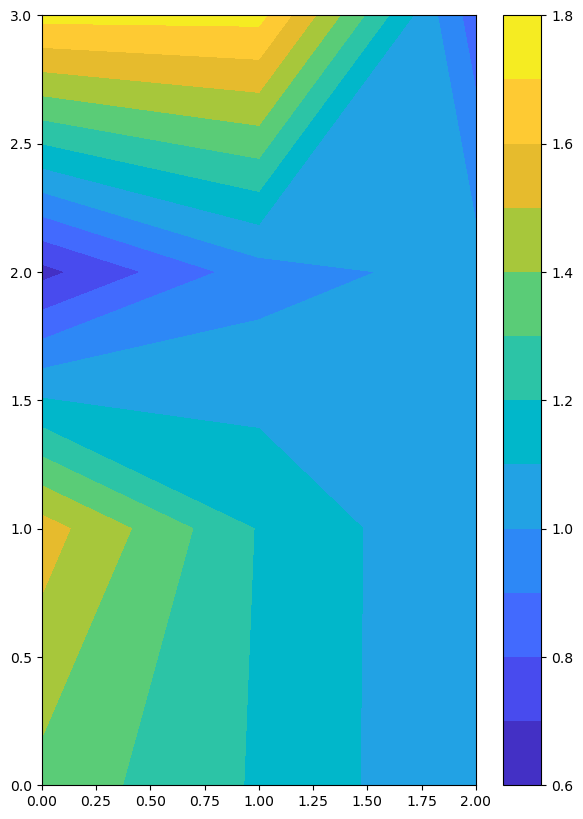

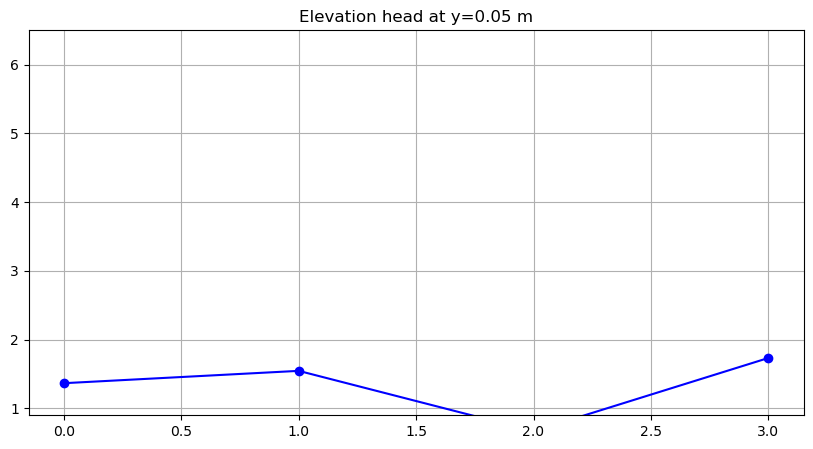

Time 0.04167
  (0, 0)	0.3136
  (1, 0)	0.04120000000000001
  (3, 0)	0.04120000000000001
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04120000000000001
  (3, 3)	0.48165799064632114
  (4, 3)	0.08591451580415227
  (6, 3)	0.051227493549526604
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08591451580415227
  (4, 4)	0.968895333078206
  (5, 4)	0.08689407575297939
  (7, 4)	0.09589607536466221
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.09589607536466221
  (6, 7)	0.10985359211307774
  (7, 7)	0.8842200339433355
  (8, 7)	0.11090924236362168
  (10, 7)	0.11912105621530268
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.045694075752979374
  (7, 8)	0.11090924236362168
  (8, 8)	0.44366899908028723
  (11, 8)	0.05972768280311172
  (6, 9)	0.059261435032358964
  (9, 9)	0.1

  (0, 0)	0.3136
  (1, 0)	0.04120000000000001
  (3, 0)	0.04120000000000001
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04120000000000001
  (3, 3)	0.47893102494011336
  (4, 3)	0.08669695574369715
  (6, 3)	0.053172019316189506
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08669695574369715
  (4, 4)	0.9665895252224598
  (5, 4)	0.08718483845342309
  (7, 4)	0.09712868058041982
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.09712868058041982
  (6, 7)	0.1100008554611433
  (7, 7)	0.8857634985117081
  (8, 7)	0.11157621225010803
  (10, 7)	0.11553075319662062
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.04598483845342308
  (7, 8)	0.11157621225010803
  (8, 8)	0.44249446188308356
  (11, 8)	0.05994448741338536
  (6, 9)	0.05471820570644497
  (9, 9)	0.1545635885871100

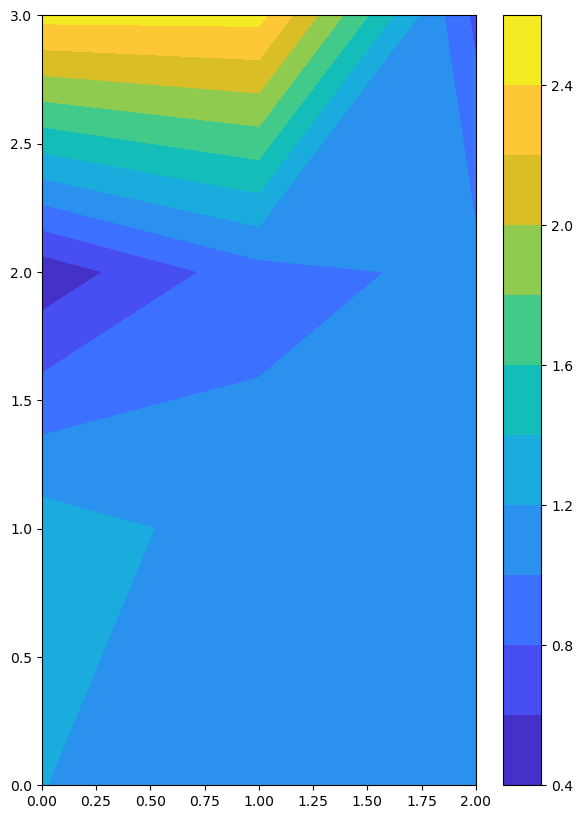

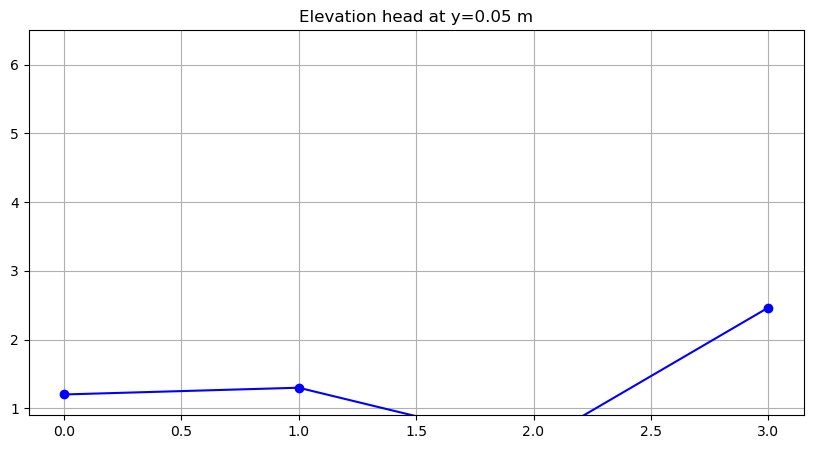

Time 0.0625
  (0, 0)	0.3136
  (1, 0)	0.04120000000000001
  (3, 0)	0.04120000000000001
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04120000000000001
  (3, 3)	0.4789200942310302
  (4, 3)	0.08670278360390593
  (6, 3)	0.05317712216506392
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08670278360390593
  (4, 4)	0.9665680320201111
  (5, 4)	0.08718985097520282
  (7, 4)	0.09713933340077996
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.09713933340077996
  (6, 7)	0.11000619622811762
  (7, 7)	0.885742298169519
  (8, 7)	0.11158110460251633
  (10, 7)	0.11553106759906695
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.045989850975202806
  (7, 8)	0.11158110460251633
  (8, 8)	0.4424844896166386
  (11, 8)	0.05994455480564229
  (6, 9)	0.054718326998825756
  (9, 9)	0.15456

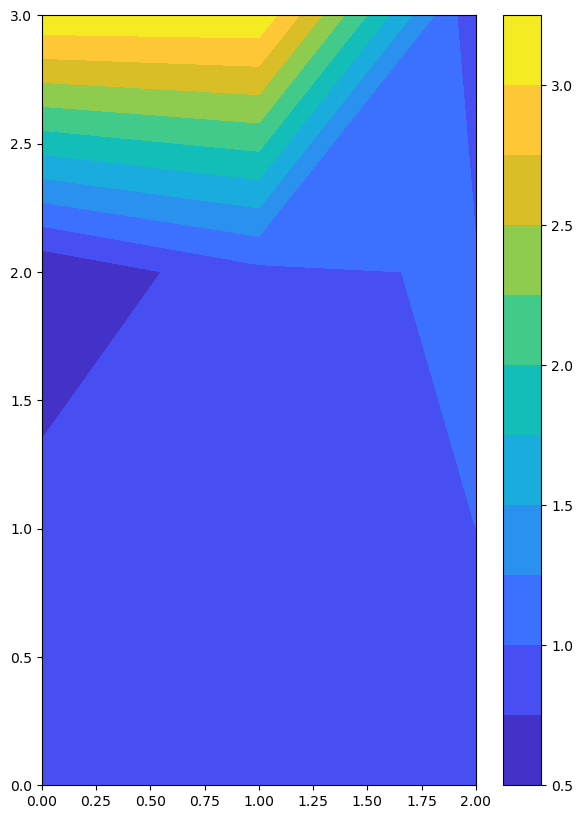

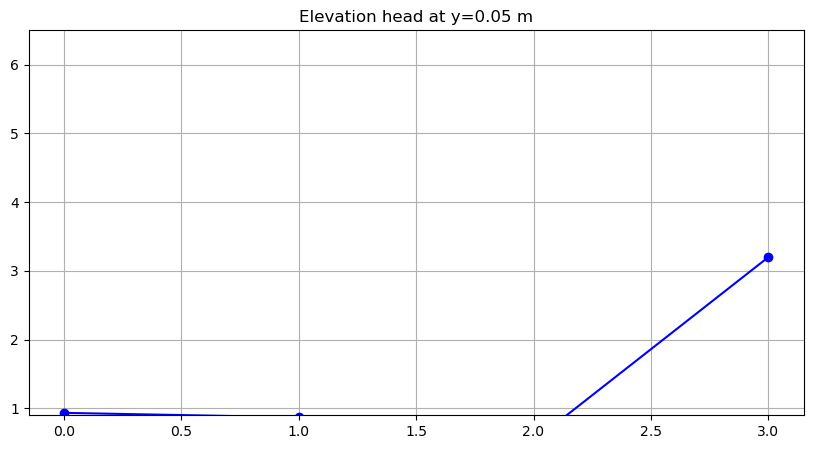

Time 0.08333
  (0, 0)	0.3136
  (1, 0)	0.04120000000000001
  (3, 0)	0.04120000000000001
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04120000000000001
  (3, 3)	0.47455338767059746
  (4, 3)	0.08934188286488041
  (6, 3)	0.05490472946452217
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08934188286488041
  (4, 4)	0.959598292119117
  (5, 4)	0.08810127060369366
  (7, 4)	0.10055855441230883
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10055855441230883
  (6, 7)	0.10826671360787676
  (7, 7)	0.8898229152720578
  (8, 7)	0.11231296259298186
  (10, 7)	0.10903885411477453
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.046901270603693646
  (7, 8)	0.11231296259298186
  (8, 8)	0.4408894757577711
  (11, 8)	0.059896291045553426
  (6, 9)	0.047117723559796786
  (9, 9)	0.16

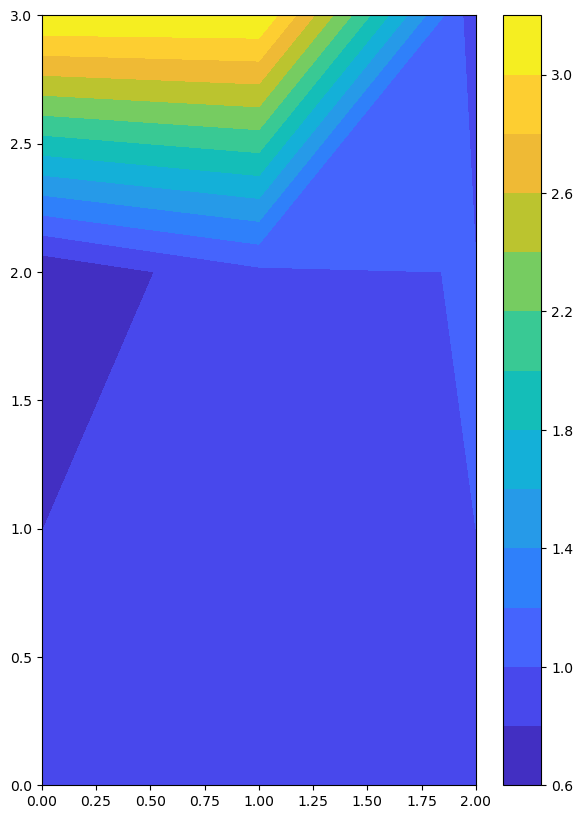

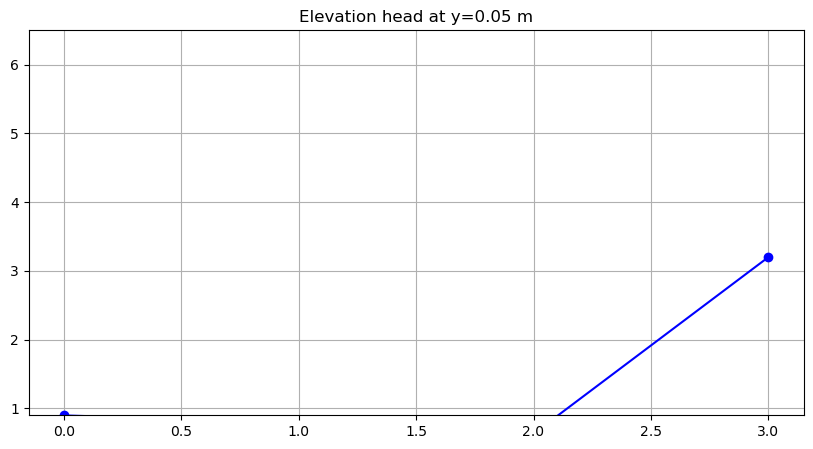

Time 0.10417
  (0, 0)	0.31341544643597347
  (1, 0)	0.04120000000000001
  (3, 0)	0.041384553564026524
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.041384553564026524
  (3, 3)	0.4739137906379118
  (4, 3)	0.08993537261003139
  (6, 3)	0.054766283188030326
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.08993537261003139
  (4, 4)	0.9582250899592201
  (5, 4)	0.08835165919347503
  (7, 4)	0.10108787823727337
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10108787823727337
  (6, 7)	0.10762652816392934
  (7, 7)	0.8907161966554297
  (8, 7)	0.11230718948299906
  (10, 7)	0.10826220746036835
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.04715165919347501
  (7, 8)	0.11230718948299906
  (8, 8)	0.4407710210317954
  (11, 8)	0.059770130291730554
  (6, 9)	0.04670930861111173

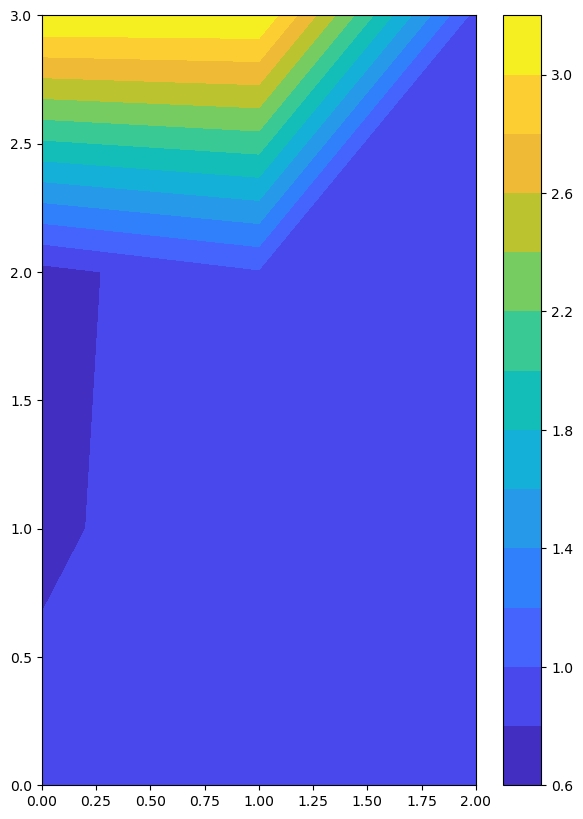

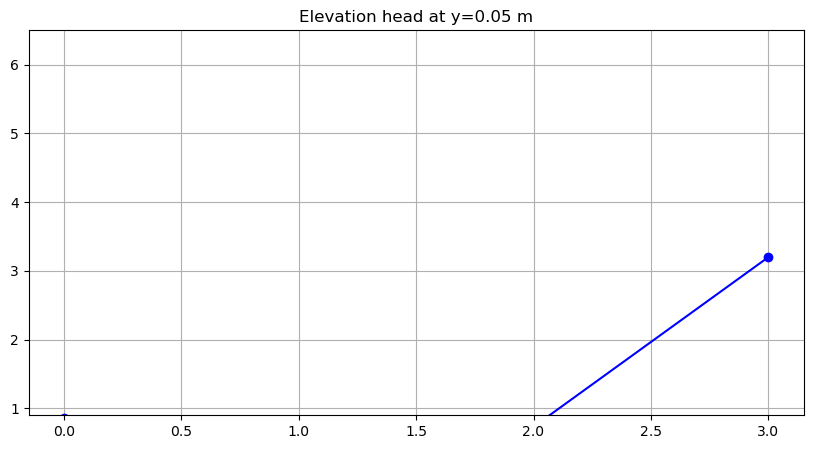

Time 0.125
  (0, 0)	0.3132508604516131
  (1, 0)	0.04120000000000001
  (3, 0)	0.04154913954838693
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04154913954838693
  (3, 3)	0.4737593263215293
  (4, 3)	0.09025134079248631
  (6, 3)	0.0544401933375975
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.09025134079248631
  (4, 4)	0.9574741033079296
  (5, 4)	0.08855960029350168
  (7, 4)	0.10131495560608222
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10131495560608222
  (6, 7)	0.1067950688201289
  (7, 7)	0.8921699500047982
  (8, 7)	0.11224196626740292
  (10, 7)	0.10747805930158771
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.047359600293501676
  (7, 8)	0.11224196626740292
  (8, 8)	0.44076922153367537
  (11, 8)	0.05962921190542009
  (6, 9)	0.04631004146679572
  (9, 

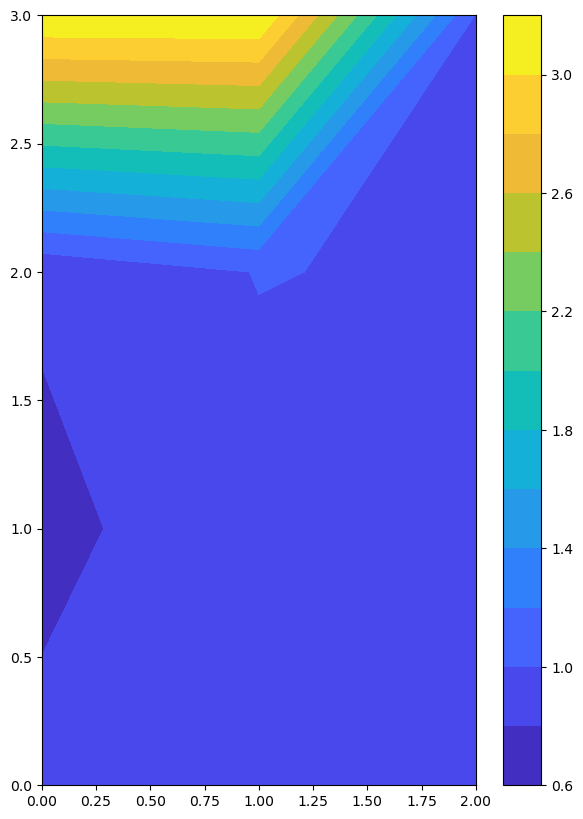

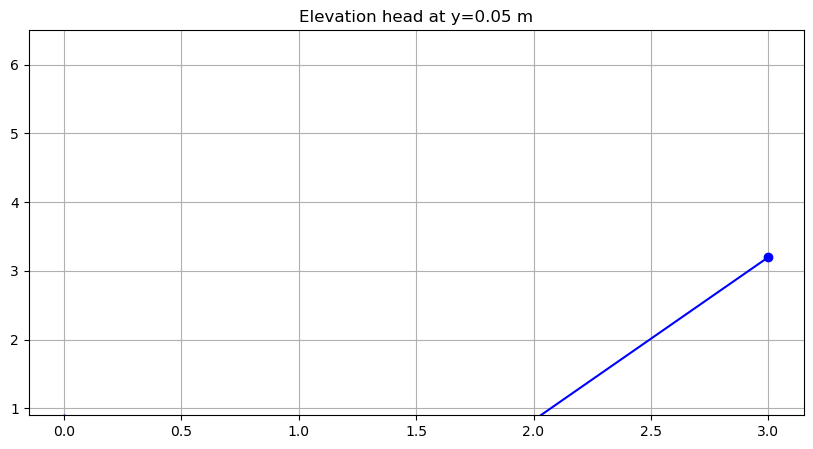

Time 0.14583
  (0, 0)	0.3131640021128027
  (1, 0)	0.04120000000000001
  (3, 0)	0.04163599788719732
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04163599788719732
  (3, 3)	0.47398200577531696
  (4, 3)	0.09035135037171882
  (6, 3)	0.054030645965766955
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.09035135037171882
  (4, 4)	0.9571881831532022
  (5, 4)	0.08871325190677305
  (7, 4)	0.10134721456830575
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10134721456830575
  (6, 7)	0.10587349450230293
  (7, 7)	0.893991539776588
  (8, 7)	0.1121058177669323
  (10, 7)	0.10668193338587091
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.04751325190677305
  (7, 8)	0.1121058177669323
  (8, 8)	0.4409069746431466
  (11, 8)	0.05947395568314806
  (6, 9)	0.04591873058698612
  (9,

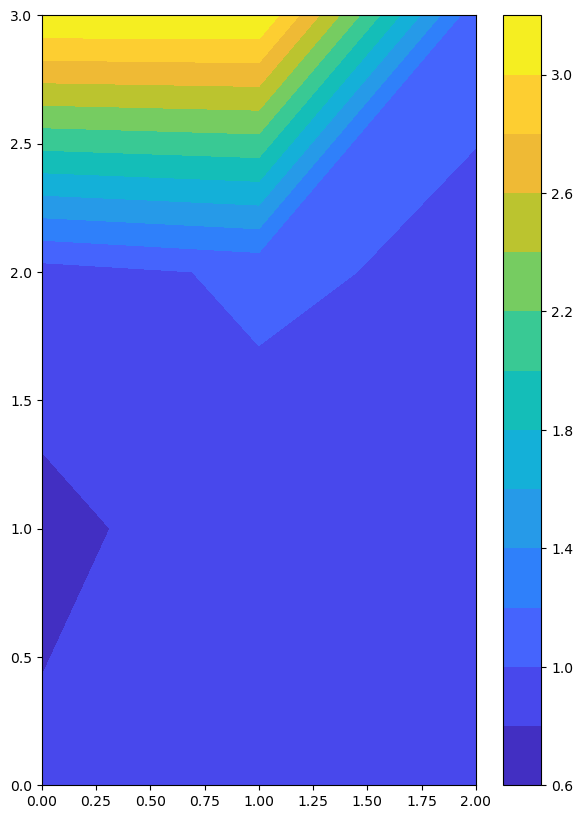

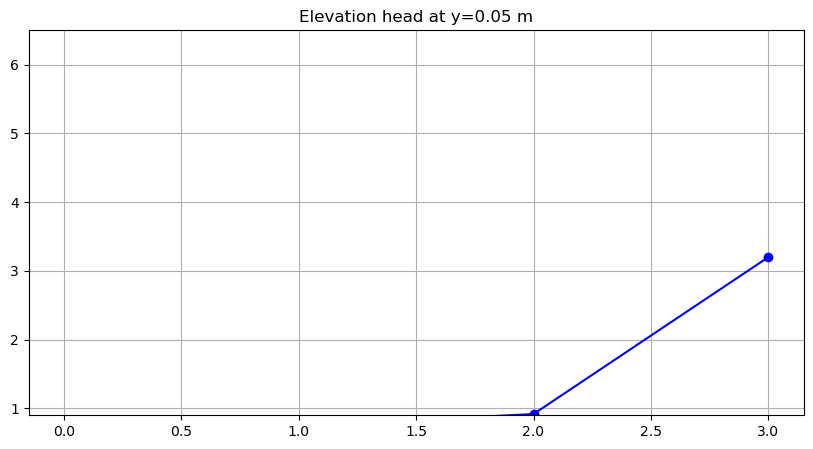

Time 0.16667
  (0, 0)	0.3131277038200518
  (1, 0)	0.04120000000000001
  (3, 0)	0.04167229617994823
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.04167229617994823
  (3, 3)	0.4744619868675324
  (4, 3)	0.09030313403454379
  (6, 3)	0.05356258291797566
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.09030313403454379
  (4, 4)	0.9572436324021969
  (5, 4)	0.08882122867333545
  (7, 4)	0.10123200488992373
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10123200488992373
  (6, 7)	0.10488521637116993
  (7, 7)	0.8961061193317817
  (8, 7)	0.11190542824000921
  (10, 7)	0.10587123116711525
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.04762122867333544
  (7, 8)	0.11190542824000921
  (8, 8)	0.44116908188197435
  (11, 8)	0.05930426120468103
  (6, 9)	0.04553510596669071
  (

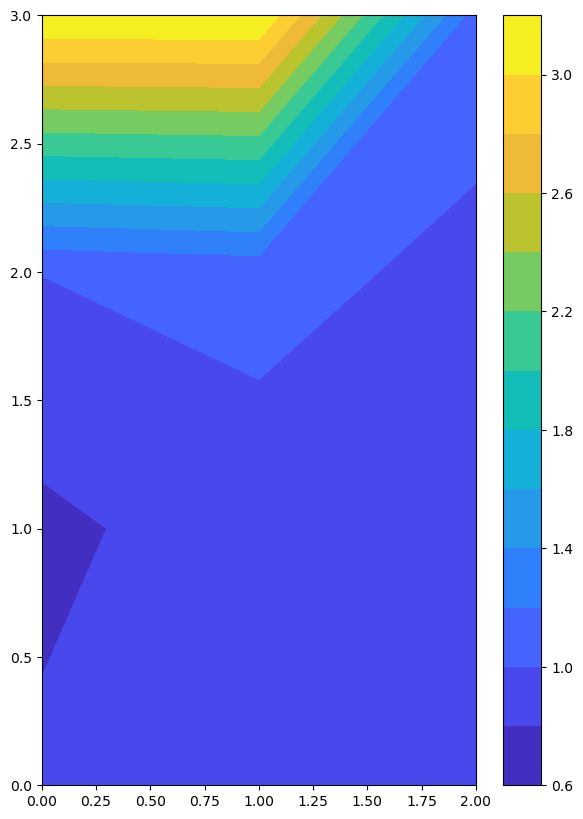

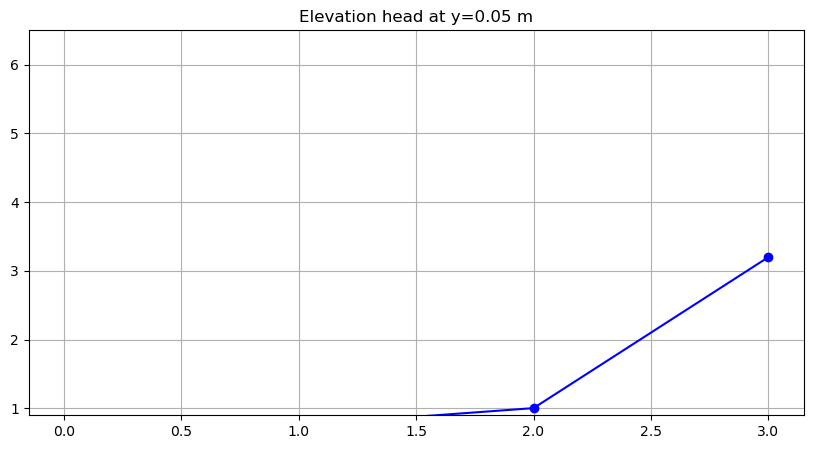

Time 0.1875
  (0, 0)	0.3131319919420422
  (1, 0)	0.04120000000000001
  (3, 0)	0.041668008057957784
  (4, 0)	0.132
  (0, 1)	0.04120000000000001
  (1, 1)	0.4952
  (2, 1)	0.04120000000000001
  (4, 1)	0.08240000000000001
  (5, 1)	0.132
  (1, 2)	0.04120000000000001
  (2, 2)	0.18159999999999998
  (5, 2)	0.04120000000000001
  (0, 3)	0.041668008057957784
  (3, 3)	0.4751535287223687
  (4, 3)	0.09013362093437513
  (6, 3)	0.05304484228529837
  (7, 3)	0.132
  (0, 4)	0.132
  (1, 4)	0.08240000000000001
  (3, 4)	0.09013362093437513
  (4, 4)	0.9575873306884842
  (5, 4)	0.08888881322915845
  (7, 4)	0.10099023514798201
  (8, 4)	0.132
  (1, 5)	0.132
  :	:
  (10, 6)	0.132
  (3, 7)	0.132
  (4, 7)	0.10099023514798201
  (6, 7)	0.10383825843083386
  (7, 7)	0.8984828815293499
  (8, 7)	0.11164436492782367
  (10, 7)	0.10504425996401048
  (11, 7)	0.132
  (4, 8)	0.132
  (5, 8)	0.047688813229158446
  (7, 8)	0.11164436492782367
  (8, 8)	0.4415470791867589
  (11, 8)	0.05911974265625902
  (6, 9)	0.04515925141501183
  

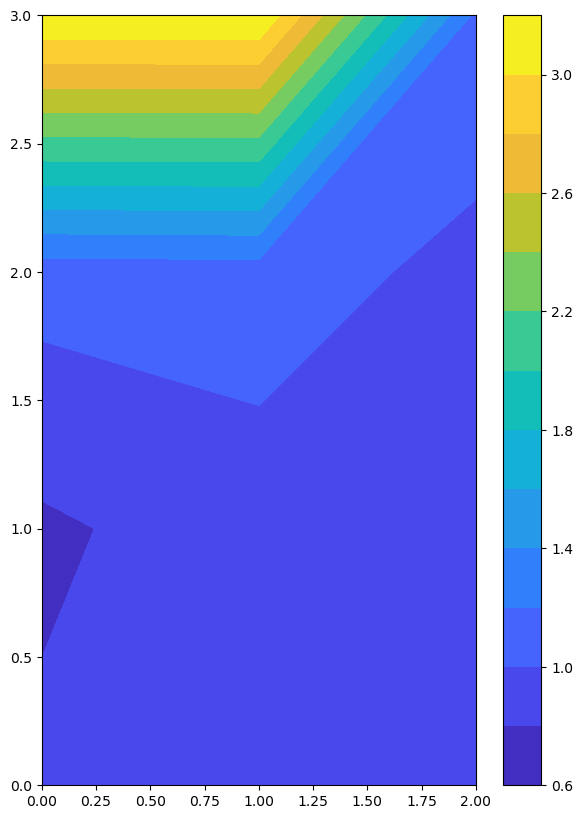

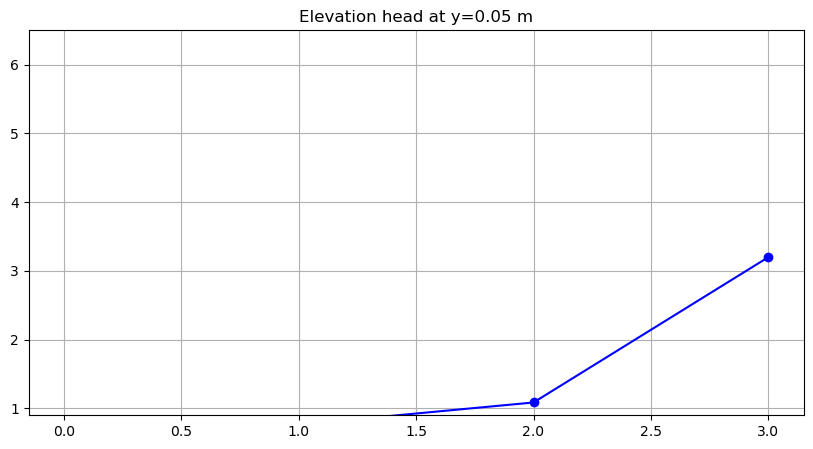

In [32]:
# Time Loop
for time_instant_index in range(1, num_steps+1):
    time = time_instant_index * dt
    print('Time ' + str(round(time, 5)))

    prev = sol

    time_rhs = np.zeros(dof_h)
    time_rhs = M_h @ theta(prev - subdomain.nodes[1,:]) / dt

    debug_saver = pp.Exporter(subdomain, str(time_instant_index) + '_sol', folder_name=os.path.join(output_directory, 'debug'))

    for k in range(K):
        mass_dtheta_local = L * M_h # mass_dtheta(prev - subdomain.nodes[1,:])

        spp = mass_dtheta_local / dt + stifness(prev - subdomain.nodes[1,:])
        

        rhs = time_rhs.copy()

        rhs += (mass_dtheta_local @ prev - M_h @ theta(prev - subdomain.nodes[1,:])) / dt

        ls = pg.LinearSystem(spp, rhs)

        print(spp, rhs)


        ls.flag_ess_bc( dirichlet_flag, dirichlet_value(time) )

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev).T @ M_h @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ M_h @ prev )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        save_step(current, debug_saver, k+1)
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break
        
    print('')    
    sol = current
    
    save_step(sol, saver, time_instant_index)

    export_csv(time_instant_index, sol, True, True)



saver.write_pvd([n * dt for n in range(num_steps + 1)])